# Model Training

In [1]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

df = pd.read_table('/kaggle/input/cancer-data/CY_all_sample_taxa.tsv', sep='\t')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Extract true/false from sample column to obtain patients having positive blood samples

In [2]:
blood = df["sample"].apply(lambda x: False if (x.endswith("N") or x.endswith("N.A") or x.endswith("Nm")) 
                               else True if (x.endswith("P") or x.endswith("P.A") or x.endswith("Pm")) else None).astype(bool)
df["blood"] = blood
columns_to_exclude = ["sample", "blood", "diagnosis", "Gender", "Age"]
df_bact = df.drop(columns_to_exclude, axis=1)

#### Function to aggregates columns to obtain bacterial counts at different taxa levels

In [3]:
df

,sample,diagnosis,D_0__Archaea;D_1__Euryarchaeota;D_2__Methanobacteria;D_3__Methanobacteriales;D_4__Methanobacteriaceae;D_5__Methanobrevibacter,D_0__Archaea;D_1__Euryarchaeota;D_2__Methanobacteria;D_3__Methanobacteriales;D_4__Methanobacteriaceae;D_5__Methanosphaera,D_0__Archaea;D_1__Euryarchaeota;D_2__Methanomicrobia;D_3__Methanomicrobiales;D_4__Methanomicrobiaceae;D_5__Methanoculleus,D_0__Archaea;D_1__Euryarchaeota;D_2__Thermoplasmata;D_3__Thermoplasmatales;D_4__Thermoplasmatales Incertae Sedis;D_5__Candidatus Methanomethylophilus,D_0__Archaea;D_1__Euryarchaeota;D_2__Thermoplasmata;D_3__Thermoplasmatales;D_4__Thermoplasmatales Incertae Sedis;D_5__Methanomassiliicoccus,D_0__Archaea;D_1__Euryarchaeota;D_2__Thermoplasmata;D_3__Thermoplasmatales;D_4__Thermoplasmatales Incertae Sedis;D_5__uncultured,D_0__Archaea;D_1__Euryarchaeota;D_2__Thermoplasmata;D_3__Thermoplasmatales;D_4__Thermoplasmatales Incertae Sedis;__,D_0__Archaea;D_1__Woesearchaeota (DHVEG-6);D_2__uncultured archaeon;D_3__uncultured archaeon;D_4__uncultured archaeon;D_5__uncultured archaeon,...,D_0__Bacteria;D_1__Verrucomicrobia;D_2__Spartobacteria;D_3__Chthoniobacterales;D_4__Chthoniobacteraceae;D_5__Chthoniobacter,D_0__Bacteria;D_1__Verrucomicrobia;D_2__Verrucomicrobiae;D_3__Verrucomicrobiales;D_4__Verrucomicrobiaceae;D_5__Akkermansia,D_0__Bacteria;D_1__Verrucomicrobia;D_2__Verrucomicrobiae;D_3__Verrucomicrobiales;D_4__Verrucomicrobiaceae;D_5__Prosthecobacter,D_0__Bacteria;D_1__Verrucomicrobia;D_2__Verrucomicrobiae;D_3__Verrucomicrobiales;D_4__Verrucomicrobiaceae;D_5__uncultured,D_0__Bacteria;D_1__Verrucomicrobia;D_2__WCHB1-41;D_3__uncultured bacterium;D_4__uncultured bacterium;D_5__uncultured bacterium,D_0__Bacteria;D_1__Verrucomicrobia;D_2__WCHB1-41;__;__;__,D_0__Bacteria;__;__;__;__;__,Age,Gender,blood
0,1002P,normal_colonoscopy,31,0,0,0,0,0,0,0,...,0,26,0,0,0,0,0,60,Male,True
1,100N,negative,0,0,0,0,0,0,0,0,...,0,10,0,0,0,0,0,64,Female,False
2,100P,cancer,0,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,64,Male,True
3,101N,negative,0,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,60,Female,False
4,101P,normal_colonoscopy,0,0,0,0,0,0,0,0,...,0,23,0,0,0,0,0,67,Female,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,97P,normal_colonoscopy,0,0,0,0,0,0,0,0,...,0,20,0,0,0,0,0,62,Male,True
2248,988P,normal_colonoscopy,186,0,0,0,0,0,0,0,...,0,12,0,0,0,0,0,62,Female,True
2249,98N,negative,103,0,0,0,6,0,0,0,...,0,64,0,0,0,0,0,69,Male,False
2250,98P,normal_colonoscopy,281,0,0,0,0,0,0,0,...,0,11421,0,0,0,0,0,60,Female,True


In [4]:
import math

def col_aggregator(df, gencol, new_gen):
    # Remove NaN values from the unique values array
    unique_vals = new_gen[gencol].dropna().unique()
    
    # Create an empty DataFrame with the unique values as columns
    aggregated_df = pd.DataFrame(columns=unique_vals)

    for index, row in df.iterrows():
        row_sum = []

        for column in unique_vals:
            agg_cols = new_gen.loc[new_gen[gencol] == column, 'Column']

            # Get the sum of all columns from agg_cols at every row
            sum_value = row[agg_cols].sum()
            row_sum.append(sum_value)

        # Add the row_sum values to the aggregated_df dataframe
        aggregated_df.loc[index] = row_sum
        
    return aggregated_df

Function to prepare dataset for modelling it does the following : -

* Normalizes the dataset to get counts between 0 and 1
* One-hot encoding of "Gender" categorical variable

In [5]:
def df_prep(aggregated_df, df, columns_to_exclude): 
    
    # Normalize values across rows
    normal_df = aggregated_df.div(aggregated_df.sum(axis=1), axis=0)
    
    # One-hot encode the "Gender" variable
    df_onehot = pd.get_dummies(df[columns_to_exclude], columns=['Gender'], drop_first=True)
    
    # Concatenate normalized data and one-hot encoded "Gender" variable
    final_df = pd.concat([normal_df, df_onehot], axis=1)
    final_df[normal_df.columns] = final_df[normal_df.columns].astype('float')
    
    return final_df

In [6]:
new_gen = pd.DataFrame(columns = ['Column','D0','D1','D2','D3','D4','D5'])
for i in range(0,len(df_bact.columns)):
    col_name = df_bact.columns[i]
    first_spl = col_name.split("D_")
    new_gen.loc[i, 'Column'] = col_name
    for j in range(1,len(first_spl)):
        sec_spl = first_spl[j].split("__")
        d = sec_spl[1][0:-1]
        new_gen.loc[i, 'D'+str(j-1)] = d

In [7]:
new_gen.groupby('D5')[['D4', 'D3', 'D2', 'D1']].nunique()

,D4,D3,D2,D1
D5,,,,
Abiotrophi,1,1,1,1
Acetitomaculu,1,1,1,1
Acetivibri,1,1,1,1
Acetobacte,1,1,1,1
Achromobacte,1,1,1,1
...,...,...,...,...
uncultured Acidobacteria bacteriu,1,1,1,1
uncultured Microgenomates group bacteriu,1,1,1,1
uncultured archaeo,1,1,1,1


In [8]:
# Assuming new_gen is your DataFrame
grouped = new_gen.groupby('D5')[['D4', 'D3', 'D2', 'D1']].nunique()

# Check if any of the grouped rows have more than 1 unique value across D4, D3, D2, D1
rows_with_different_values = grouped[(grouped > 1).any(axis=1)]

if not rows_with_different_values.empty:
    print("Rows with different values across D4, D3, D2, D1:")
    print(rows_with_different_values)
else:
    print("All rows have the same values across D4, D3, D2, D1.")

Rows with different values across D4, D3, D2, D1:
                           D4  D3  D2  D1
D5                                       
unculture                  32  23  19  11
uncultured bacteriu        24  29  32  21
uncultured rumen bacteriu   4   4   4   4


In [9]:
new_gen['D1'].unique()

array(['Euryarchaeota', 'Woesearchaeota (DHVEG-6)', 'Acidobacteria',
       'Actinobacteria', 'Armatimonadetes', 'Bacteroidetes', 'Chlamydiae',
       'Chlorobi', 'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
       'Elusimicrobia', 'Fibrobacteres', 'Firmicutes', 'Fusobacteria',
       'Gemmatimonadetes', 'Gracilibacteria', 'Lentisphaerae',
       'Microgenomates', 'Nitrospirae', 'Parcubacteria',
       'Peregrinibacteria', 'Planctomycetes', 'Proteobacteria',
       'SR1 (Absconditabacteria)', 'Saccharibacteria', 'Spirochaetae',
       'Synergistetes', 'TM6 (Dependentiae)', 'Tenericutes',
       'Verrucomicrobia', nan], dtype=object)

In [10]:
aggregated_df1 = col_aggregator(df_bact,'D1',new_gen)

In [11]:
aggregated_df2 = col_aggregator(df_bact,'D2',new_gen)
aggregated_df2 = aggregated_df2.drop(['uncultured archaeon','uncultured bacterium'], axis = 1)

In [12]:
aggregated_df3 = col_aggregator(df_bact,'D3',new_gen)
aggregated_df3 = aggregated_df3.drop(['uncultured archaeon','uncultured bacterium'], axis = 1)

In [13]:
aggregated_df4 = col_aggregator(df_bact,'D4',new_gen)
aggregated_df4 = aggregated_df4.drop(['uncultured archaeon','uncultured bacterium'], axis = 1)

In [14]:
aggregated_df5 = col_aggregator(df_bact,'D5',new_gen)
aggregated_df5 = aggregated_df5.drop(['uncultured archaeo','uncultured bacteriu','unculture'], axis = 1)

In [15]:
final_df1 = df_prep(aggregated_df1,df,columns_to_exclude)
final_df2 = df_prep(aggregated_df2,df,columns_to_exclude)
final_df3 = df_prep(aggregated_df3,df,columns_to_exclude)
final_df4 = df_prep(aggregated_df4,df,columns_to_exclude)
final_df5 = df_prep(aggregated_df5,df,columns_to_exclude)

In [16]:
from sklearn.model_selection import train_test_split

def stratified_train_test_split(df):
    # Assuming 'target_column' is the column by which you want to stratify the split
    target_column = 'diagnosis'
    
    # Perform stratified train-test split
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[target_column], random_state=42)
    
    return train_df, test_df

train1,test1 = stratified_train_test_split(final_df1)
train2,test2 = stratified_train_test_split(final_df2)
train3,test3 = stratified_train_test_split(final_df3)
train4,test4 = stratified_train_test_split(final_df4)
train5,test5 = stratified_train_test_split(final_df5)

In [17]:
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE
import joblib

def rf_model_with_rfe(clean_data, reduce_n):
    cleaned_feature_names = [re.sub(r'[<>\[\]]', '_', col) for col in clean_data.columns]
    clean_data.columns = cleaned_feature_names
    # Perform nested cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

    best_selected_features = None
    best_score = None
    best_model = None
    
    # Define the parameter search space for Bayesian optimization
    param_space = {
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 12),
        'min_samples_split': Real(0.1, 1.0),
        'min_samples_leaf': Real(0.1, 0.5),
        'max_features': Categorical(['auto', 'sqrt', 'log2']),
        'bootstrap': Categorical([True, False])
    }
    
    # Create a mapping dictionary
    diagnosis_mapping = {diagnosis: index for index, diagnosis in enumerate(clean_data['diagnosis'].unique())}
    
    clean_data["diagnosis"] = clean_data["diagnosis"].map(diagnosis_mapping).astype(int)

    for train_index, test_index in outer_cv.split(clean_data.drop("diagnosis", axis=1), clean_data["diagnosis"]):
        train_data, test_data = clean_data.iloc[train_index], clean_data.iloc[test_index]

        # Perform Recursive Feature Selection (RFE)
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=reduce_n)
        rfe.fit(train_data.drop("diagnosis", axis=1), train_data["diagnosis"])

        # Get selected feature indices
        selected_indices = rfe.support_
        
        # Select the features in the training data
        train_data_selected = train_data.drop("diagnosis", axis=1).iloc[:, selected_indices]
        test_data_selected = test_data.drop("diagnosis", axis=1).iloc[:, selected_indices]

        # Perform Bayesian optimization with cross-validation
        opt = BayesSearchCV(
            estimator=RandomForestClassifier(),
            search_spaces=param_space,
            scoring="accuracy",
            n_iter=10,
            cv=inner_cv,
            verbose=False
        )

        # Fit the Bayesian optimization on the training data
        opt.fit(train_data_selected, train_data["diagnosis"])

        # Get the best hyperparameters found
        best_params = opt.best_params_

        # Train the Random Forest model with the best hyperparameters
        rf_model = RandomForestClassifier(**best_params)
        rf_model.fit(train_data_selected, train_data["diagnosis"])

        # Predict target variable for test data
        pred_test_rf = rf_model.predict(test_data_selected)

        # Calculate accuracy
        acc = accuracy_score(test_data["diagnosis"], pred_test_rf)

        # Calculate recall
        recall = recall_score(test_data["diagnosis"], pred_test_rf, average="weighted")

        # Calculate precision
        precision = precision_score(test_data["diagnosis"], pred_test_rf, average="weighted")

        # Calculate F1 score
        f1 = f1_score(test_data["diagnosis"], pred_test_rf, average="weighted")

        # Calculate score using the formula
        score = 0.25 * acc + 0.25 * recall + 0.25 * precision + 0.25 * f1
        
        print("Score:", score, "\n")

        # Update the best score and best model if the current score is better
        if best_score is None or score > best_score:
            best_score = score
            best_model = rf_model
            best_selected_features = train_data_selected.columns.tolist()

    # Print the best score
    print("Best Score:", best_score, "\n")
    
    # Save the best model and best features using joblib
    joblib.dump(best_model, str(len(train_data_selected.columns))+'best_rf_model.pkl')
    joblib.dump(best_selected_features, str(len(train_data_selected.columns))+'best_rfselected_features.pkl')
    joblib.dump(diagnosis_mapping, str(len(train_data_selected.columns))+'best_rfmodel_labels.pkl')

    return best_score, best_model, diagnosis_mapping, best_selected_features

def get_featimps_rf(model, feature_names):
    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a dictionary to store feature importance
    features = {}

    # Iterate over the feature names and importances
    for feature_name, importance in zip(feature_names, feature_importances):
        # Store the feature importance with the corresponding feature name
        features[feature_name] = importance

    # Sort the features by importance in descending order
    features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}

    return features

In [18]:
import re
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE
import joblib

def xgb_model_with_rfe(clean_data, reduce_n):
     
    cleaned_feature_names = [re.sub(r'[<>\[\]]', '_', col) for col in clean_data.columns]
    clean_data.columns = cleaned_feature_names
    # Perform nested cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

    best_selected_features = None
    best_score = None
    best_model = None
    
    # Define the parameter search space for Bayesian optimization
    param_space = {
        'eta': Real(0.01, 0.5),
        'learning_rate': Real(0.01, 0.5),
        'max_depth': Integer(3, 12),
        'subsample': Real(0.2, 1),
        'colsample_bytree': Real(0.5, 1),
        'lambda': Real(0.0, 10.0),
        'alpha': Real(0.0, 10.0),
        'gamma': Real(0.0, 10.0),
        'n_estimators': Integer(100, 500)
    }
    
    # Set parameters for LightGBM
    params = {
        "objective": "multi:softprob",
        "metric": "mlogloss",
        "num_class": len(clean_data["diagnosis"].unique()),
        "boosting_type": "gblinear",
        'verbosity': 0
    }
    
    # Create a mapping dictionary
    diagnosis_mapping = {diagnosis: index for index, diagnosis in enumerate(clean_data['diagnosis'].unique())}
    
    clean_data["diagnosis"] = clean_data["diagnosis"].map(diagnosis_mapping).astype(int)

    for train_index, test_index in outer_cv.split(clean_data.drop("diagnosis", axis=1), clean_data["diagnosis"]):
        train_data, test_data = clean_data.iloc[train_index], clean_data.iloc[test_index]

        # Perform Recursive Feature Selection (RFE)
        rfe = RFE(estimator=xgb.XGBClassifier(), n_features_to_select=reduce_n)
        rfe.fit(train_data.drop("diagnosis", axis=1), train_data["diagnosis"])

        # Get selected feature indices
        selected_indices = rfe.support_
        
        # Select the features in the training data
        train_data_selected = train_data.drop("diagnosis", axis=1).iloc[:, selected_indices]
        test_data_selected = test_data.drop("diagnosis", axis=1).iloc[:, selected_indices]

        # Perform Bayesian optimization with cross-validation
        opt = BayesSearchCV(
            estimator=xgb.XGBClassifier(),
            search_spaces=param_space,
            scoring="accuracy",
            n_iter=10,
            cv=inner_cv,
            verbose=False
        )

        # Fit the Bayesian optimization on the training data
        opt.fit(train_data_selected, train_data["diagnosis"])

        # Get the best hyperparameters found
        best_params = opt.best_params_

        # Train the XGBoost model with the best hyperparameters
        xgb_model = xgb.XGBClassifier(**best_params)
        xgb_model.fit(train_data_selected, train_data["diagnosis"])

        # Predict target variable for test data
        pred_test_xgb = xgb_model.predict(test_data_selected)

        # Calculate accuracy
        acc = accuracy_score(test_data["diagnosis"], pred_test_xgb)

        # Calculate recall
        recall = recall_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate precision
        precision = precision_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate F1 score
        f1 = f1_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate score using the formula
        score = 0.25 * acc + 0.25 * recall + 0.25 * precision + 0.25 * f1
        
        print("Score:", score, "\n")

        # Update the best score and best model if the current score is better
        if best_score is None or score > best_score:
            best_score = score
            best_model = xgb_model
            best_selected_features = train_data_selected.columns.tolist()

    # Print the best score
    print("Best Score:", best_score, "\n")
    
    # Save the best model and best features using joblib
    joblib.dump(best_model, str(len(train_data_selected.columns))+'best_xgb_model.pkl')
    joblib.dump(best_selected_features, str(len(train_data_selected.columns))+'best_selected_features.pkl')
    joblib.dump(diagnosis_mapping, str(len(train_data_selected.columns))+'best_model_labels.pkl')

    return best_score, best_model, diagnosis_mapping, best_selected_features

def get_featimps_xg(model):
    # Get feature names
    feature_names = model.feature_names_in_

    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a dictionary to store feature importance
    features = {}

    # Iterate over the feature names and importances
    for feature_name, importance in zip(feature_names, feature_importances):
        # Store the feature importance with the corresponding feature name
        features[feature_name] = importance

    # Sort the features by importance in descending order
    features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}

    return features

In [19]:
print (len(train1.columns))
print (len(train2.columns))
print (len(train3.columns))
print (len(train4.columns))
print (len(train5.columns))

36
68
102
173
429


In [20]:
"""model1 = joblib.load('/kaggle/input/model1/20best_selected_features.pkl')
labels1 = joblib.load('/kaggle/input/model1/20best_xgb_model.pkl')
best_features1 = joblib.load('/kaggle/input/model1/20best_model_labels.pkl')"""
#To load models after already running everything

"model1 = joblib.load('/kaggle/input/model1/20best_selected_features.pkl')\nlabels1 = joblib.load('/kaggle/input/model1/20best_xgb_model.pkl')\nbest_features1 = joblib.load('/kaggle/input/model1/20best_model_labels.pkl')"

In [21]:
score1, model1, labels1, best_features1 = xgb_model_with_rfe(train1.drop(['sample','blood'],axis = 1),20)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.28024608737236234 

Score: 0.3279818315403523 

Score: 0.2850727957098259 

Score: 0.2854772674501621 

Score: 0.33502694127028265 

Best Score: 0.33502694127028265 



In [22]:
score2, model2, labels2, best_features2 = xgb_model_with_rfe(train2.drop(['sample','blood'],axis = 1),30)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.2860009783249545 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.3110072604742169 

Score: 0.32546350170628857 

Score: 0.3377516424905507 

Score: 0.28962706761852386 

Best Score: 0.3377516424905507 



In [23]:
score3, model3, labels3, best_features3 = xgb_model_with_rfe(train3.drop(['sample','blood'],axis = 1),50)

Score: 0.3255680954828967 

Score: 0.31862264913761684 

Score: 0.30733587895060177 

Score: 0.31514550648595824 

Score: 0.3136699177863751 

Best Score: 0.3255680954828967 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
score4, model4, labels4, best_features4 = xgb_model_with_rfe(train4.drop(['sample','blood'],axis = 1),75)

Score: 0.3716125823904388 

Score: 0.34019750220538675 

Score: 0.2929306800026802 

Score: 0.2740677538054659 

Score: 0.3661190684588595 

Best Score: 0.3716125823904388 



In [25]:
score5, model5, labels5, best_features5 = xgb_model_with_rfe(train5.drop(['sample','blood'],axis = 1),100)

Score: 0.3448854905424936 

Score: 0.36627561493756683 

Score: 0.3480451117306607 

Score: 0.3336979391763409 

Score: 0.31749629186076556 

Best Score: 0.36627561493756683 



In [26]:
scorerf1, modelrf1, labelsrf1, best_rffeatures1 = rf_model_with_rfe(train1.drop(['sample','blood'],axis = 1),20)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.20603211738745333 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.25508002630858495 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.21587577215553405 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.23136028491969718 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.24639988847907246 

Best Score: 0.25508002630858495 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
scorerf2, modelrf2, labelsrf2, best_rffeatures2 = rf_model_with_rfe(train2.drop(['sample','blood'],axis = 1),30)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.24048078742232532 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.3018016812903133 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.24902554814750408 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.25470083505596597 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.23959812711686534 

Best Score: 0.3018016812903133 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
scorerf3, modelrf3, labelsrf3, best_rffeatures3 = rf_model_with_rfe(train3.drop(['sample','blood'],axis = 1),50)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.2118277754364798 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.2282007296330213 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.22929737372579653 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.254394574828369 

Score: 0.24951516424582088 

Best Score: 0.254394574828369 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
scorerf4, modelrf4, labelsrf4, best_rffeatures4 = rf_model_with_rfe(train4.drop(['sample','blood'],axis = 1),75)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.2640079821424311 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.22125725969679771 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.24179822148664842 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.2118176230287812 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.25976846652588914 

Best Score: 0.2640079821424311 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
scorerf5, modelrf5, labelsrf5, best_rffeatures5 = rf_model_with_rfe(train5.drop(['sample','blood'],axis = 1),100)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.24273479067549808 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.22103814860001272 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.249514218505156 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.23164327071928234 



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Score: 0.2770690674038776 

Best Score: 0.2770690674038776 



In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_and_plot(best_model, diagnosis_mapping, best_selected_features, test_data):
    # Map back the diagnosis labels
    test_data["diagnosis"] = test_data["diagnosis"].map(diagnosis_mapping).astype(int)
    
    # Select the features in the test data
    test_data_selected = test_data.drop("diagnosis", axis=1)[best_selected_features]

    # Predict target variable for test data
    pred_test = best_model.predict(test_data_selected)

    # Calculate accuracy
    acc = accuracy_score(test_data["diagnosis"], pred_test)

    # Calculate recall
    recall = recall_score(test_data["diagnosis"], pred_test, average="weighted")

    # Calculate precision
    precision = precision_score(test_data["diagnosis"], pred_test, average="weighted")

    # Calculate F1 score
    f1 = f1_score(test_data["diagnosis"], pred_test, average="weighted")

    print("Weighted Accuracy:", acc)
    print("Weighted Recall:", recall)
    print("Weighted Precision:", precision)
    print("Weighted F1-score:", f1)

    # Calculate ROC curve and AUC for each class
    # Convert to one-hot encoding
    y_true = label_binarize(test_data["diagnosis"], classes=list(diagnosis_mapping.values()))
    y_pred = label_binarize(pred_test, classes=list(diagnosis_mapping.values()))
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    reverse_mapping = {v: k for k, v in diagnosis_mapping.items()}

    # Plot the ROC curves with string labels
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        class_label = reverse_mapping[i]
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

Weighted Accuracy: 0.3436807095343681
Weighted Recall: 0.3436807095343681
Weighted Precision: 0.29951113442802957
Weighted F1-score: 0.2985779907758615


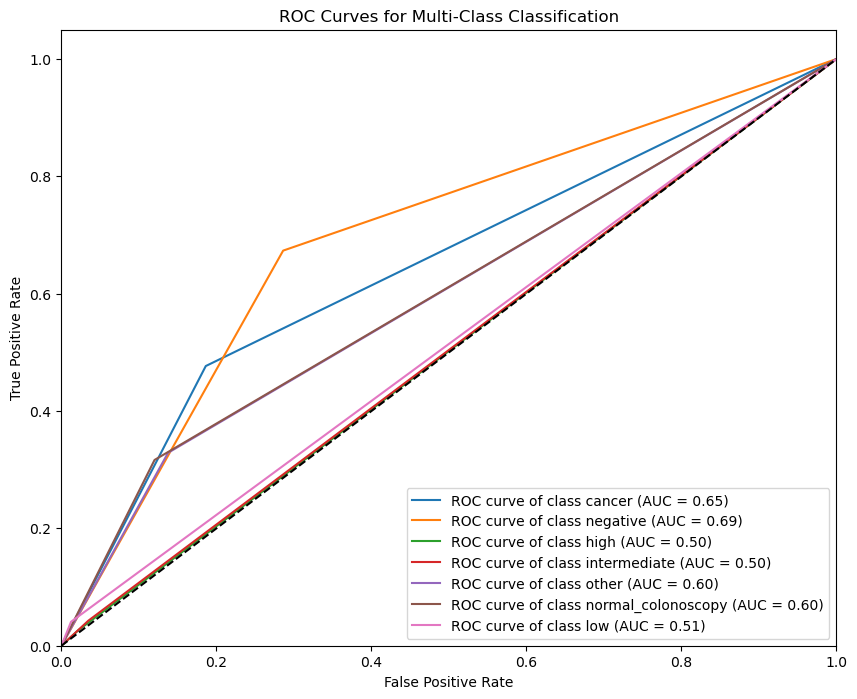

In [32]:
evaluate_and_plot(model1, labels1, best_features1, test1.drop(['sample','blood'],axis = 1))

Weighted Accuracy: 0.34146341463414637
Weighted Recall: 0.34146341463414637
Weighted Precision: 0.31162942630842244
Weighted F1-score: 0.30381835800230617


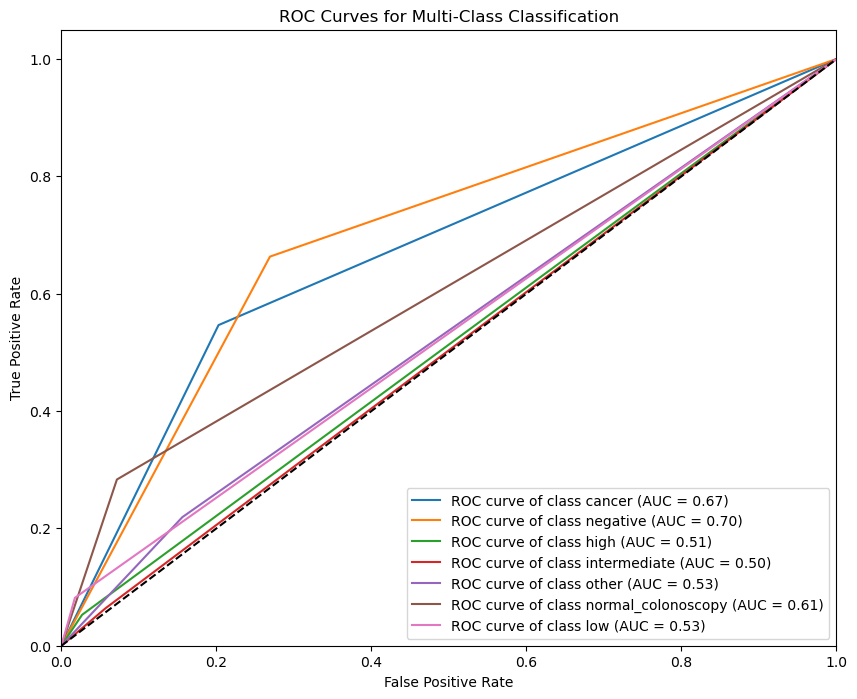

In [33]:
evaluate_and_plot(model2, labels2, best_features2, test2.drop(['sample','blood'],axis = 1))

Weighted Accuracy: 0.37028824833702884
Weighted Recall: 0.37028824833702884
Weighted Precision: 0.30611495324423066
Weighted F1-score: 0.3270996101856403


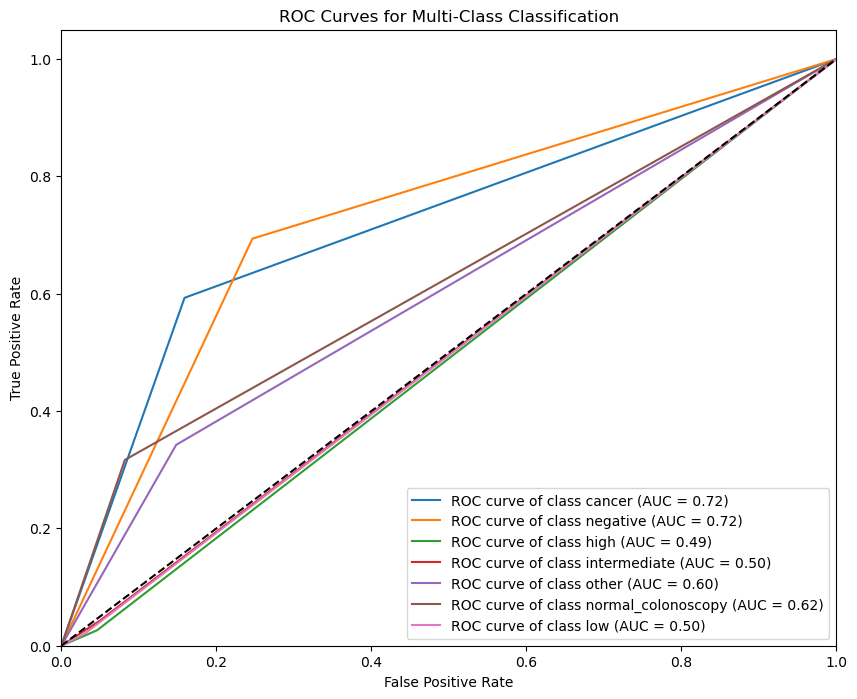

In [34]:
evaluate_and_plot(model3, labels3, best_features3, test3.drop(['sample','blood'],axis = 1))

Weighted Accuracy: 0.34811529933481156
Weighted Recall: 0.34811529933481156
Weighted Precision: 0.314201478439322
Weighted F1-score: 0.30458678605612527


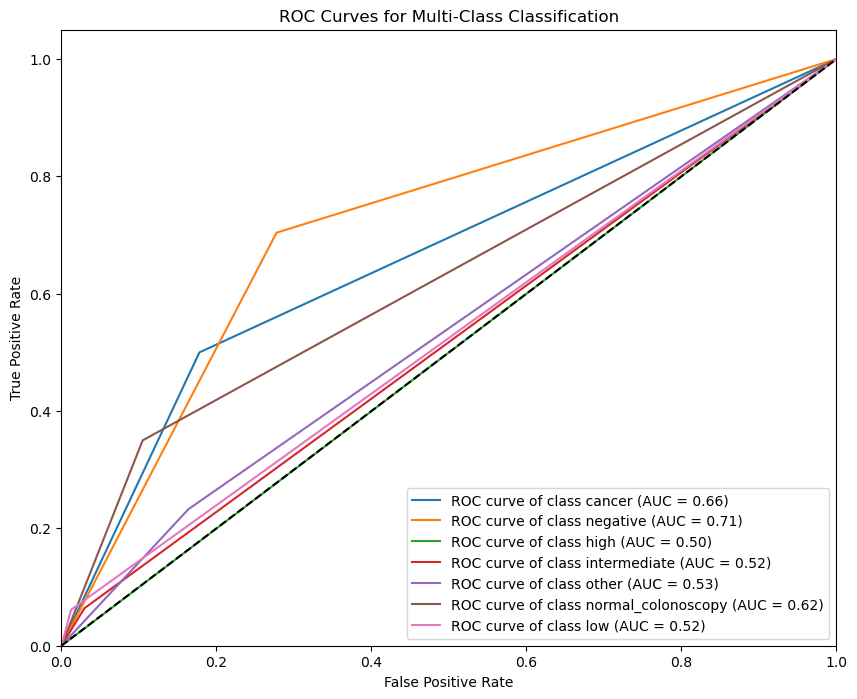

In [35]:
evaluate_and_plot(model4, labels4, best_features4, test4.drop(['sample','blood'],axis = 1))

Weighted Accuracy: 0.3370288248337029
Weighted Recall: 0.3370288248337029
Weighted Precision: 0.296331197987476
Weighted F1-score: 0.3086450873800951


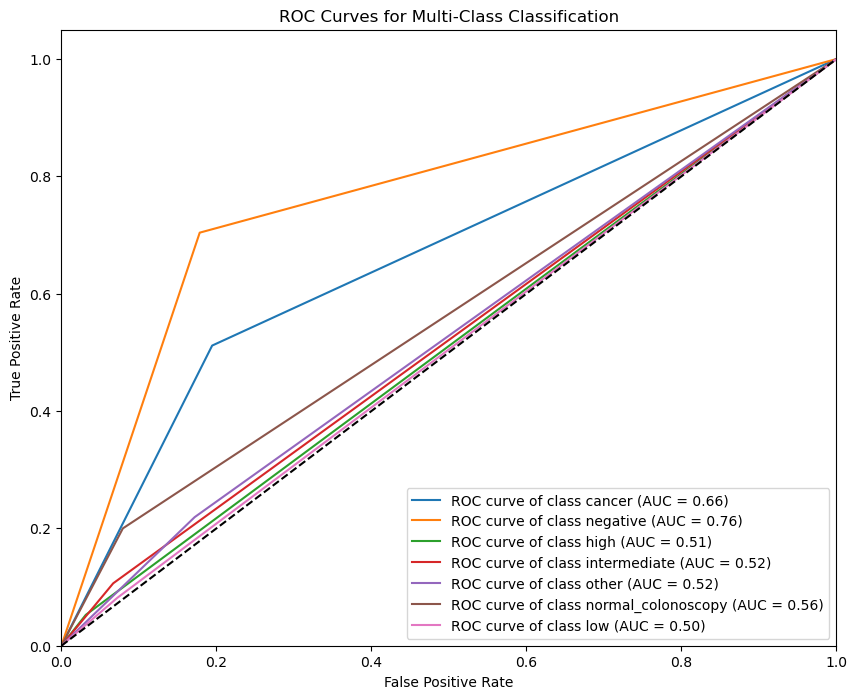

In [36]:
cleaned_feature_names = [re.sub(r'[<>\[\]]', '_', col) for col in test5.columns]
test5.columns = cleaned_feature_names
evaluate_and_plot(model5, labels5, best_features5, test5.drop(['sample','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Accuracy: 0.3259423503325942
Weighted Recall: 0.3259423503325942
Weighted Precision: 0.18380997388275871
Weighted F1-score: 0.224643823418511


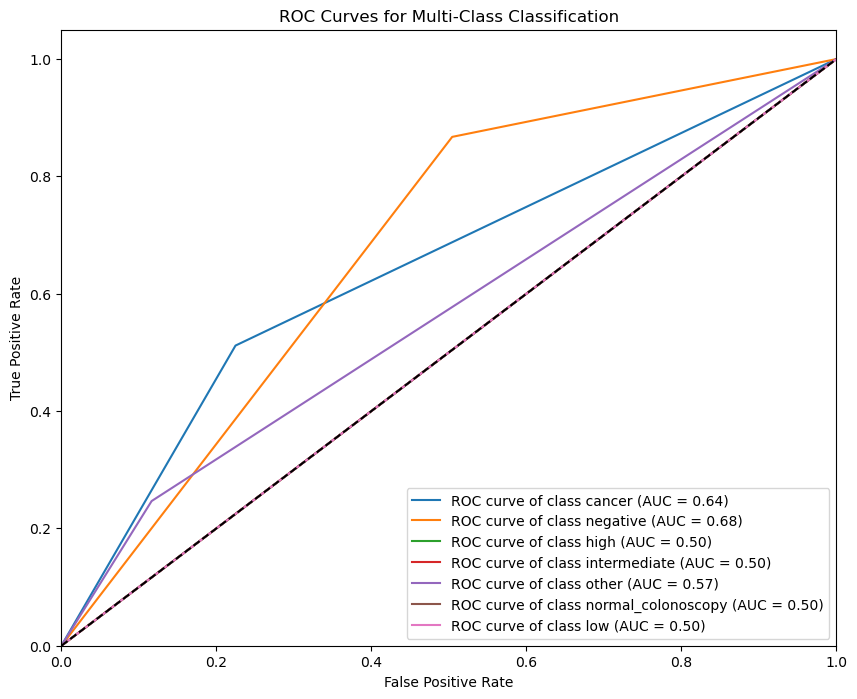

In [37]:
evaluate_and_plot(modelrf1, labelsrf1, best_rffeatures1, test1.drop(['sample','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Accuracy: 0.3392461197339246
Weighted Recall: 0.3392461197339246
Weighted Precision: 0.32839093686729465
Weighted F1-score: 0.23943641210733083


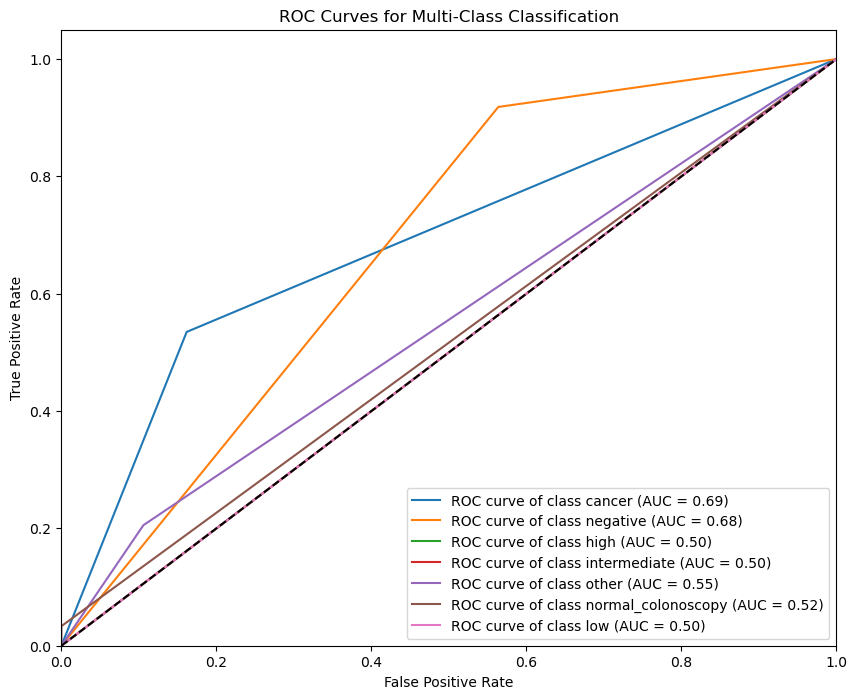

In [38]:
evaluate_and_plot(modelrf2, labelsrf2, best_rffeatures2, test2.drop(['sample','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Accuracy: 0.3082039911308204
Weighted Recall: 0.3082039911308204
Weighted Precision: 0.18849146738147915
Weighted F1-score: 0.20414714491907146


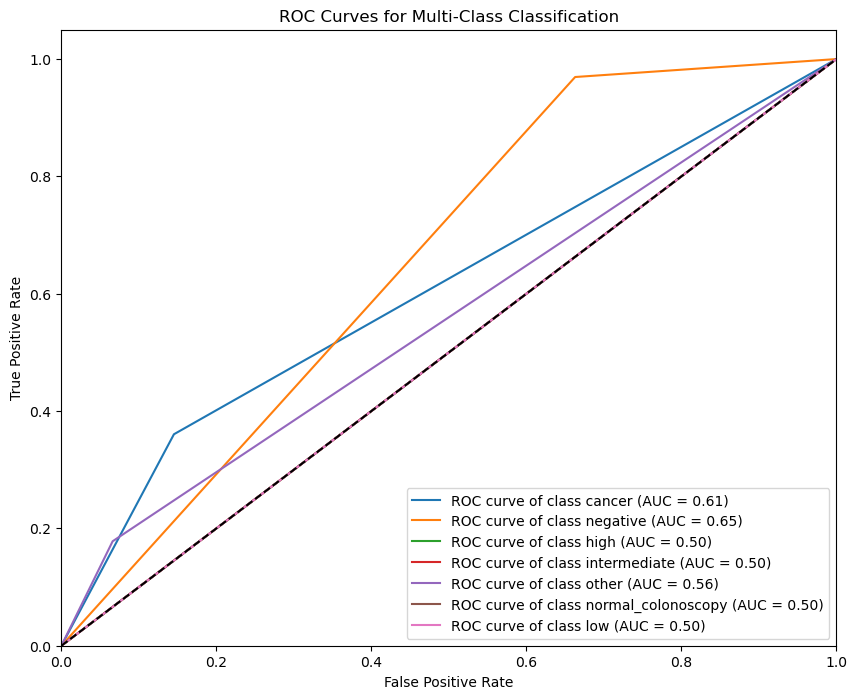

In [39]:
evaluate_and_plot(modelrf3, labelsrf3, best_rffeatures3, test3.drop(['sample','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Accuracy: 0.3237250554323725
Weighted Recall: 0.3237250554323725
Weighted Precision: 0.31912779929285057
Weighted F1-score: 0.22603251698222965


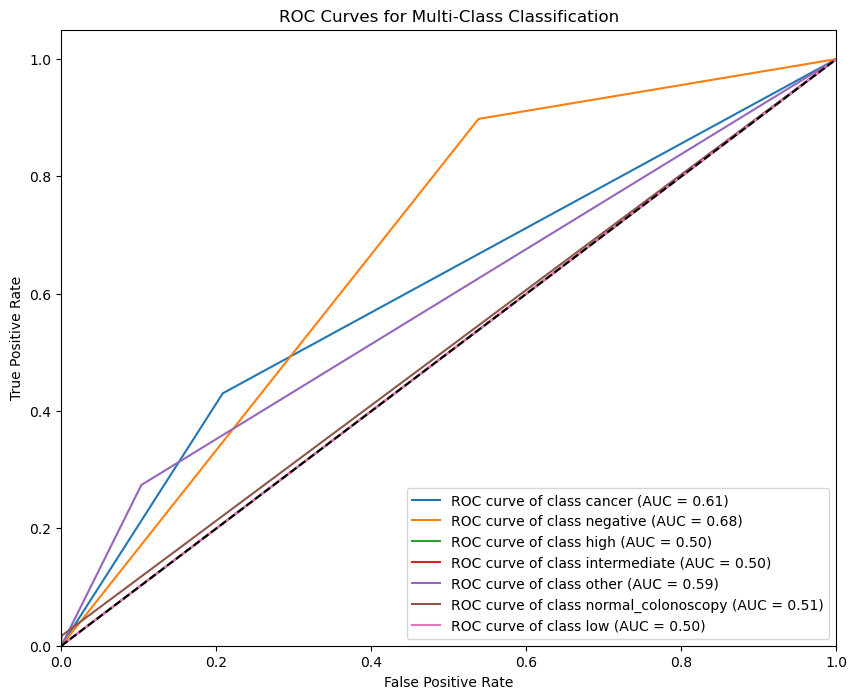

In [40]:
evaluate_and_plot(modelrf4, labelsrf4, best_rffeatures4, test4.drop(['sample','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Accuracy: 0.3215077605321508
Weighted Recall: 0.3215077605321508
Weighted Precision: 0.22125466876647049
Weighted F1-score: 0.23303461347789856


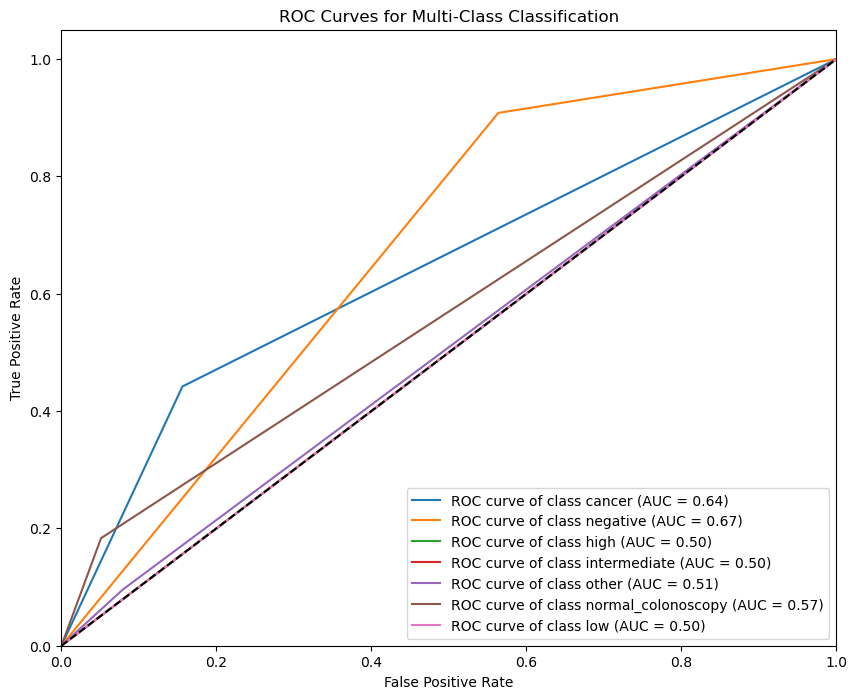

In [41]:
evaluate_and_plot(modelrf5, labelsrf5, best_rffeatures5, test5.drop(['sample','blood'],axis = 1))